<div class="container">
<div class="jumbotron">
    <h1 style="font-weight: bold; font-size: 2em;">CPSC 425: Computer Vision</h1>      
    <p style="margin-bottom: 1em; font-family: sans-serif; text-align: justify;">
        Assignment 6: Deep Learning
    </p>
    Attribution: This assignment is developed based on the example <a href="https://github.com/pytorch/examples/blob/master/mnist/main.py">here</a>.
</div>
</div>

# Preface

This assignment consists of three parts: In the first part, you will implement various PyTorch deep learning layers using Numpy; in part two, you will experiment with different hyper-parameters on a image classification task and find the best hyper-parameters; lastly, you will investigate a state-of-the-art neural architecture from the PyTorch model zoo.

**IMPORTANT**: Colab allows you to train your network in either a cpu or a **free** gpu. You can request a Colab GPU by clicking on the `Edit-Notebook Settings-HardwareAccelerator` and choose `GPU`. After you chose the GPU, the python program will restart from scratch. If you run the cell below, you will see whether a GPU has been assigned to you. If you cannot get a GPU on time, you can simply use a cpu, which should work for this assignment but slower.

**IMPORTANT**: Before proceeding, it is important to understand what is Google Colab notebooks. You can play around with this short tutorial [here](https://colab.research.google.com/notebooks/intro.ipynb)

In [1]:
!nvidia-smi

Mon Apr 11 05:12:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    62W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Implement Neural Network Layers

In this section, you are going to implement some fundamental deep learning layers of PyTorch using numpy arrays. Through this implementation, you will gain better understandings of the deep learning tools we introduced in class, such as activation functions, linear layers, max pooling layers and convolution layers. As we mentioned in class, each deep learning layer has two operators: `forward` and `backward`. In the forward pass, data are piped through a computational graph (each node is a deep learning layer) to obtain the final prediction. When comparing the prediction with a loss, gradients are backpropagated in the inverse direction of the graph, which allows us to compute the gradients with respect to the model parameters and we can follow the negative gradient to update the parameters (a.k.a. learning the parameters).

You will be implementing the `forward` pass of the `ReLU`, `MaxPool2d`, `Linear`, and `Conv2d` layers. Since the `backward` pass is quite intensive, we only require you to implement it for ther `ReLU` layer. Although in practice, most deep learning library (such as PyTorch) would compute the gradients for you automatically using the computational graph, which is called `AutoGrad`, sometimes you do need to implement your custom gradient backward.

Let's kick start by importing the following dependencies:

In [2]:
import torch
import torch.nn as nn
import numpy as np
import hw_utils

## ReLU Activation `[2 marks]`

Implement the ReLU layer by filling in numpy code in between `START` and `END`. The assertions should tell you what we expect your input and output to be (such as the shape and the data type). Note that for ReLU, the input can be in any shape. Your solution should produce a numpy array that is very close to the outputs of a PyTorch implementations, which you can check by looking at the errors from the tests below. DO NOT remove the tests and include the errors in your final version upon submission.

In [3]:
# TODO
class nn_ReLU():
    def __init__(self):
        pass
    def forward(self, X):
        assert isinstance(X, np.ndarray)
        in_shape = X.shape
        # START
        # f(x) = max(0,x)
        out = X
        out[X<0] = 0
        # END
        assert isinstance(out, np.ndarray)
        assert out.shape == X.shape
        return out
    
    def backward(self, X):
        # compute the gradient of y with respect to X
        # where y = ReLU(X)
        grad = np.ones_like(X)
        # START
        # The gradient of ReLU is 1 for x>0 and 0 for x<0.
        # 1s are already assigned, we need to decide the zero entries.
        grad[X<0] = 0
        # END
        return grad

# Note: the following test cases only test for the forward function. 
hw_utils.test_relu(in_shape=[7, 5, 3, 1], Layer=nn_ReLU)
hw_utils.test_relu(in_shape=[100], Layer=nn_ReLU)
hw_utils.test_relu(in_shape=[3, 4, 4], Layer=nn_ReLU)

norm(out_np - out_torch) = 0.000000
norm(out_np - out_torch) = 0.000000
norm(out_np - out_torch) = 0.000000


## Maxpooling Layer `[2 marks]`

Implement the 2d pooling layer by filling in numpy code in between `START` and `END`. The assertions should tell you what we expect your input and output to be (such as the shape and the data type). Note that for 2d max pooling, you will work with inputs with shape `(N, C, size, size)` where `N` is the number of examples, `C` is the channel size, and `size` is the width and height of the feature map. The stride of this max pooling would be `size` as well. Your solution should produce a numpy array that is very close to the outputs of a PyTorch implementations, which you can check by looking at the errors from the tests below. DO NOT remove the tests and include the errors in your final version upon submission.

In [4]:
# TODO
class nn_MaxPool2d():
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size
        
    def forward(self, X):
        assert isinstance(X, np.ndarray)
        assert len(X.shape) == 4
        assert X.shape[2] == X.shape[3],\
            'You can assume width and height are the same'
        N, C, size, _ = X.shape
        assert size >= self.kernel_size,\
            'You can assume the feature map is always at least as big as the kernel size'
        kernel_size = self.kernel_size
        
        # START
        # Wo = (Wi-F)/S + 1
        # Ho = Wo since width and height are the same.
        # Also stride S = F in this example (it is given).
        out_size = int((size-kernel_size)/kernel_size) + 1
        out = np.ndarray((N, C, out_size, out_size))

        # Find the window that has kernel_size x kernel_size
        for n in range(N):
          for c in range(C):
            for i in range(out_size):
              for j in range(out_size):
                row_start = i*kernel_size
                column_start = j*kernel_size
                window = X[n, c, row_start:row_start+kernel_size, column_start:column_start+kernel_size]
                # Find the max entry in this window, and assign it to the output
                out[n,c,i,j] = np.amax(window)
        # END
        out = out.reshape(N, C, out_size, out_size)
        return out

hw_utils.test_maxpool(N=3, C=6, size=4, kernel_size=1, Layer=nn_MaxPool2d)
hw_utils.test_maxpool(N=3, C=6, size=4, kernel_size=2, Layer=nn_MaxPool2d)
hw_utils.test_maxpool(N=3, C=6, size=4, kernel_size=4, Layer=nn_MaxPool2d)

hw_utils.test_maxpool(N=3, C=6, size=16, kernel_size=4, Layer=nn_MaxPool2d)
hw_utils.test_maxpool(N=3, C=6, size=16, kernel_size=8, Layer=nn_MaxPool2d)

hw_utils.test_maxpool(N=3, C=6, size=15, kernel_size=4, Layer=nn_MaxPool2d)
hw_utils.test_maxpool(N=3, C=6, size=15, kernel_size=8, Layer=nn_MaxPool2d)

hw_utils.test_maxpool(N=3, C=6, size=13, kernel_size=4, Layer=nn_MaxPool2d)
hw_utils.test_maxpool(N=3, C=6, size=13, kernel_size=8, Layer=nn_MaxPool2d)

norm(out_np - out_torch) = 0.000003
norm(out_np - out_torch) = 0.000002
norm(out_np - out_torch) = 0.000001
norm(out_np - out_torch) = 0.000005
norm(out_np - out_torch) = 0.000002
norm(out_np - out_torch) = 0.000004
norm(out_np - out_torch) = 0.000001
norm(out_np - out_torch) = 0.000003
norm(out_np - out_torch) = 0.000001


## Linear Layer `[2 marks]`

Implement the linear layer by filling in numpy code in between `START` and `END`. The assertions should tell you what we expect your input and output to be (such as the shape and the data type). Note that for this layer, you will work with inputs with shape `(N, D)` where `N` is the number of examples, `D` is feature dimension. Your solution should produce a numpy array that is very close to the outputs of a PyTorch implementations, which you can check by looking at the errors from the tests below. DO NOT remove the tests and include the errors in your final version upon submission.

In [5]:
# TODO
class nn_Linear():
    def __init__(self, in_features, out_features):
        self.W = np.random.rand(in_features, out_features)
        self.b = np.random.rand(1, out_features)
        
    def forward(self, X):
        assert isinstance(X, np.ndarray)
        assert len(X.shape) == 2
        N, D = X.shape
        
        # START
        # y = W^T X + b
        y = np.matmul(X, self.W) + self.b
        # END
        
        assert len(y.shape) == 2
        assert y.shape[0] == N
        return y
    
    def load_weights(self, W, b):
        W = W.T
        b = b.reshape(1, -1)
        assert W.shape == self.W.shape
        assert b.shape == self.b.shape
        self.W = W
        self.b = b

hw_utils.test_linear(N=3, D=4, K=5, Layer=nn_Linear)
hw_utils.test_linear(N=5, D=6, K=7, Layer=nn_Linear)
hw_utils.test_linear(N=1, D=4, K=5, Layer=nn_Linear)
hw_utils.test_linear(N=1, D=1, K=1, Layer=nn_Linear)
hw_utils.test_linear(N=2, D=1, K=1, Layer=nn_Linear)
hw_utils.test_linear(N=1, D=2, K=2, Layer=nn_Linear)

norm(out_np - out_torch) = 0.000001
norm(out_np - out_torch) = 0.000002
norm(out_np - out_torch) = 0.000000
norm(out_np - out_torch) = 0.000000
norm(out_np - out_torch) = 0.000000
norm(out_np - out_torch) = 0.000000


## Convolution Layer `[4 marks]`

Implement the 2d convolution layer by filling in numpy code in between `START` and `END`. The assertions should tell you what we expect your input and output to be (such as the shape and the data type). Note that for this layer, you will work with inputs with shape `(N, D, size, size)` where `N` is the number of examples, `D` is channel dimension, `size` is the width/height. Your solution should produce a numpy array that is very close to the outputs of a PyTorch implementations, which you can check by looking at the errors from the tests below. DO NOT remove the tests and include the errors in your final version upon submission.

In [6]:
# TODO
class nn_Conv2d():
    def __init__(self, in_channels, out_channels, kernel_size):
        assert kernel_size % 2  == 1, "We assume the kernel_size to be odd."
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        # START
        self.linear = nn_Linear(in_features=kernel_size*kernel_size*in_channels, out_features=out_channels)
        # END
        
    def forward(self, X):
        assert isinstance(X, np.ndarray)
        assert len(X.shape) == 4
        assert X.shape[2] == X.shape[3]
        N, C, size, _ = X.shape
        assert size >= self.kernel_size
        kernel_size = self.kernel_size
        # START
        # Wo = (Wi-F+2P)/S + 1
        # Ho = Wo since width and height are the same.
        # Also stride S = 1, and P = 0 in this example.
        out_size = size - kernel_size + 1;
        out = np.ndarray((N, self.out_channels, out_size, out_size))

        # Slide over the image spatially, computing dot products.
        for i in range(out_size):
          for j in range(out_size):
            # Taking a dot product between the filter and a small part of the image.
            # Find this small (kernel_size x kernel_size x C) part of the image.
            window = X[:, :, i:i+kernel_size, j:j+kernel_size]
            # Stretch the image patch to perform the dot product
            strecthed_window = np.reshape(window,(N, kernel_size*kernel_size*self.in_channels))
            out[:,:,i,j] = self.linear.forward(strecthed_window)
        # END
        assert len(out.shape) == 4
        assert out.shape[0] == X.shape[0]
        assert out.shape[1] == self.out_channels
        assert out.shape[2] == out.shape[3]
        return out
    
    def load_weights(self, W, b):
        self.linear.load_weights(W, b)
        

hw_utils.test_conv2d(N=4, D=5, K=6, size=3, kernel_size=3, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=4, D=5, K=6, size=5, kernel_size=3, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=4, D=5, K=6, size=10, kernel_size=3, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=1, D=5, K=6, size=5, kernel_size=3, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=4, D=5, K=1, size=5, kernel_size=3, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=4, D=1, K=6, size=3, kernel_size=3, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=1, D=1, K=1, size=5, kernel_size=3, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=4, D=5, K=6, size=10, kernel_size=1, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=4, D=5, K=6, size=10, kernel_size=5, Layer=nn_Conv2d)
hw_utils.test_conv2d(N=4, D=5, K=6, size=10, kernel_size=7, Layer=nn_Conv2d)

norm(out_np - out_torch) = 0.000023
norm(out_np - out_torch) = 0.000048
norm(out_np - out_torch) = 0.000172
norm(out_np - out_torch) = 0.000042
norm(out_np - out_torch) = 0.000017
norm(out_np - out_torch) = 0.000010
norm(out_np - out_torch) = 0.000006
norm(out_np - out_torch) = 0.000103
norm(out_np - out_torch) = 0.000281
norm(out_np - out_torch) = 0.000255


# Experimenting with a CNN classifier

## Introducing the setup

In this section, you will be experimenting with various hyper-parameters of a CNN classifier on the CIFAR10 dataset. CIFAR10 is a dataset of images of objects in 10 categories. It is widely used for benchmarking image classification models. Since most students have very limited computational resources, to make the training and validation more feasible, we subsampled the dataset so that we have 5000 images for training, 5000 images for validation and 5000 images for testing.

As shown below, our neural network consists of two parts: `cnn` and `linear_layers`. Given an arbitray image from CIFAR10, the image will flow through the network in the same order shown in the printout. It first goes through a convolutional network and then flows into the linear layers for classifications. 

In details, the `cnn` module is a sequence of 2d convolution layers and non-linear activation layers with 2d max pooling. You can fetch the CIFAR10 dataset and visualize the network structure by executing the lines below:

In [7]:
train_loader, val_loader, test_loader\
    = hw_utils.fetch_data()

Files already downloaded and verified
Files already downloaded and verified
len(train_set) = 5000, len(val_set) = 5000, len(test_set) = 5000


In [8]:
args = {
    'lr': 1e-3,
    'epoch': 10,
    'channel1': 32,
    'channel2': 128,
    'mid_dims': [256, 32],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(
    args, train_loader, val_loader, skip_train=True)

Net(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (linear_layers): MLP(
    (model): ModuleList(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=10, bias=True)
    )
  )
)


The above printout is analogous to the interface you used in the first part of this assignment. For example, `Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))` denotes a 2d convolution layer with an input channel of size 3, an output channel of size 32, a 2d convolution kernel size of 3 by 3, and a stride of 1. After the second convolution, we apply max pooling on the spatial dimension to reduce the resolution of the input feature map using `MaxPool2d(kernel_size=2, stride=2, padding=0)`. The `cnn` module outputs a feature map of shape `(N, 64, 4, 4)`, which denotes the number of examples, feature map channel depth, channel_width, and channel_height respectively. We then "flatten" the feature map in shape `(N, 64, 4, 4)` to single vectors in shape `(N, 64*4*4)=(N, 1024) ` and let the vectors go through a feedforward classifier. 

Since the purpose is for you to experiment with deep learning architectures, you are not required to manually create your own PyTorch network from scratch. Like our previous assignment, we have all of the boilerplate code written for you. **As a result, you only need to interact with the `args` object**, which stores the hyperparameters for creating the network and for training.

For example, `args['channel1']` and `args['channel2']` are the channel sizes of the convolution layers; `args['mid_dims']` stores the intermediate size of hidden layers. Compare the below network structure to the above to understand what eack key of `args` represents:

~~~
Net(
  (cnn): Sequential(
    (0): Conv2d(3, args['chanell1'], kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(args['chanell1'], args['chanell2'], kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(args['chanell2'], 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (linear_layers): MLP(
    (model): ModuleList(
      (0): Linear(in_features=1024, out_features=args['mid_dims'][0], bias=True)
      (1): ReLU()
      (2): Linear(in_features=args['mid_dims'][0], out_features=args['mid_dims'][1], bias=True)
      (3): ReLU()
      (4): Linear(in_features=args['mid_dims'][1], out_features=10, bias=True)
    )
  )
)
~~~

There are other hyper-parameters in `args`. For example, `args['lr']` is the learning rate at each iteration for training; `args['epoch']` is the number of times we train on the training set (if epoch is 2, you will go through the 5000 training examples for twice); `args['act_name']` is the activation function to use to introduce non-linearity. 

**IMPORTANT**: Colab allows you to train your network in either a cpu or a **free** gpu. You can request a Colab GPU by clicking on the `Edit-Notebook Settings-HardwareAccelerator` and choose `GPU`. After you chose the GPU, the python program will restart from scratch. As to `args`, you can specify the device to use for training by setting `args['device'] = 'cpu'` or `args['device'] = 'cuda'`. We highly recommend you to use a GPU provided by Colab, which should speed up your development process. 

## First Deep Learning Model

Now that the setup is done. Lets create and train our first deep learning model! The below cell specifies the arguments using `args`. The function `spawn_train_show` creates the model based on the configuration in `args`, trains the model, and plots the validation metrics as a figure. The left side of the figure shows the training and validation loss as we train the model across epochs; the right side shows the accuracies. It is normal that your accuracy is below `50%` because we are using a small fraction of the entire dataset and the default `args` is not optimal.

Net(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (linear_layers): MLP(
    (model): ModuleList(
      (0): Linear(in_features=1024, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=10, bias=True)
    )
  )
)


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: training loss = 1.9941, validation loss = 2.0206
Epoch 2: training loss = 1.7515, validation loss = 1.7799
The highest validation accuracy is 32.70 percent
The highest training accuracy is 34.48 percent


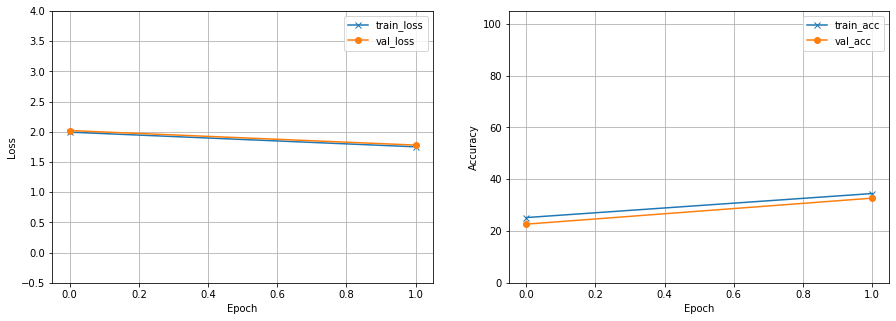

In [9]:
args = {
    'lr': 1e-3,
    'epoch': 2,
    'channel1': 16,
    'channel2': 16,
    'mid_dims': [16, 16],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(
    args, train_loader, val_loader, print_model=True, print_loss=True)

## Experiment: number of epochs `[2 marks]`

Use the following configuration as default (you may use either `cpu` or `cuda`):
~~~
args = {
    'lr': 1e-3,
    'epoch': 10,
    'channel1': 128,
    'channel2': 256,
    'mid_dims': [512, 512],
    'act_name': 'relu',
    'device': 'cuda'
}
~~~
and experiment different `args['epoch']`. Report one configuration that underfit the network, and one configuration that overfits the network. Make sure you provide the `args` that you used, and the plots generated by that `args`. You can avoid printing the loss and models by setting `print_model=False`, `print_loss=False` in `spawn_train_show`.

  0%|          | 0/3 [00:00<?, ?it/s]

The highest validation accuracy is 42.28 percent
The highest training accuracy is 46.88 percent


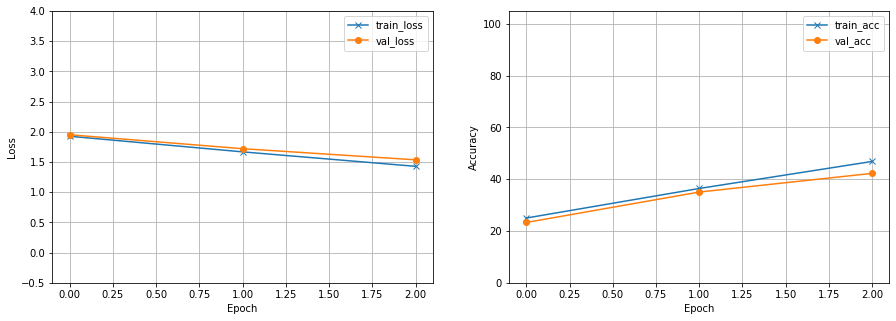

In [10]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 3,
    'channel1': 128,
    'channel2': 256,
    'mid_dims': [512, 512],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Underfitting: Epoch=3**

---

In both 2 interval, validation loss is decreasing while the validation accuracy is increasing. It shows that we are on the correct track, so we should continue. When epoch = 3, the model is underfitted.

  0%|          | 0/35 [00:00<?, ?it/s]

The highest validation accuracy is 49.36 percent
The highest training accuracy is 98.30 percent


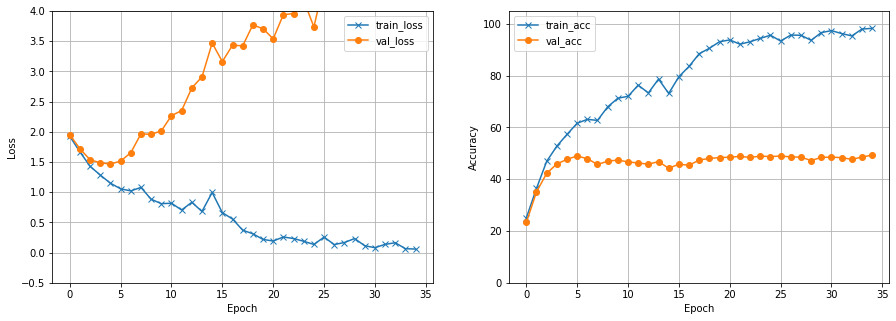

In [11]:
args = {
    'lr': 1e-3,
    'epoch': 35,
    'channel1': 128,
    'channel2': 256,
    'mid_dims': [512, 512],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Overfitting: Epoch=35**

---

Validation loss started to increase after epoch = 5. And at the same time, validation accuracy didn't increase for a while. It is almost constant, also at some points, we can see a little decrease. So, we don't need to use that large epoch number. When epoch = 35, the model is overfitted.

## Experiment: Channel Sizes `[2 marks]`
Use the following configuration as default (you may use either `cpu` or `cuda`):
~~~
args = {
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 16,
    'channel2': 16,
    'mid_dims': [256, 256],
    'act_name': 'relu',
    'device': 'cuda'
}
~~~
and experiment different combinations of `args['channel1']` and `args['channel2']`. Report one configuration that underfit the network, and one configuration that overfits the network. Make sure you provide the `args` that you used, and the plots generated by that `args`. You can avoid printing the loss and models by setting `print_model=False`, `print_loss=False` in `spawn_train_show`.

  0%|          | 0/20 [00:00<?, ?it/s]

The highest validation accuracy is 38.18 percent
The highest training accuracy is 84.94 percent


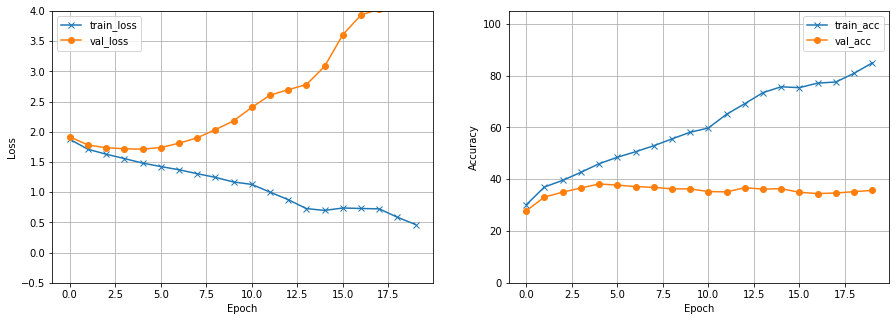

In [12]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 2,
    'channel2': 2,
    'mid_dims': [256, 256],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Underfitting: 2x2**

---

With the default setting (16x16), I got 48.94% accuracy. Approximately, this is the maximum accury value that we can reach. However, with 2x2 configuration, we only got 38.18% of accuracy. So, 2x2 channel size underfits the model.

  0%|          | 0/20 [00:00<?, ?it/s]

The highest validation accuracy is 47.44 percent
The highest training accuracy is 81.04 percent


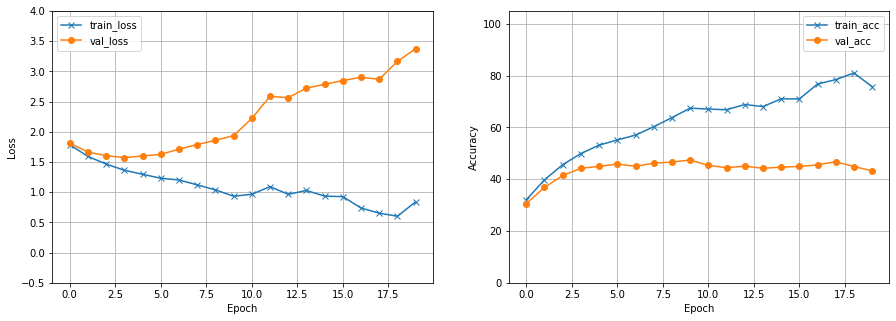

In [13]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 512,
    'channel2': 512,
    'mid_dims': [256, 256],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Overfitting: 512x512**

---

With the default setting (16x16), I got 48.94% validation accuracy. Approximately, this is the maximum accury value that we can reach. However, with 5122x5122 configuration, we got 47.44% of validation accuracy. Accuracy started to decrease from the optimal value. So, 512x512 channel size overfits the model.

## Experiment: Linear Hidden Layer Width `[2 marks]`
Use the following configuration as default (you may use either `cpu` or `cuda`):
~~~
args = {
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 256,
    'channel2': 256,
    'mid_dims': [D, D],
    'act_name': 'relu',
    'device': 'cuda'
}
~~~
and experiment different `args['mid_dims'] = [D, D]` with different integer `D` (note that `args['mid_dims']` is a list of integers). Report one configuration that underfit the network, and one configuration that overfits the network. Make sure you provide the `args` that you used, and the plots generated by that `args`. You can avoid printing the loss and models by setting `print_model=False`, `print_loss=False` in `spawn_train_show`.

  0%|          | 0/20 [00:00<?, ?it/s]

The highest validation accuracy is 10.30 percent
The highest training accuracy is 10.40 percent


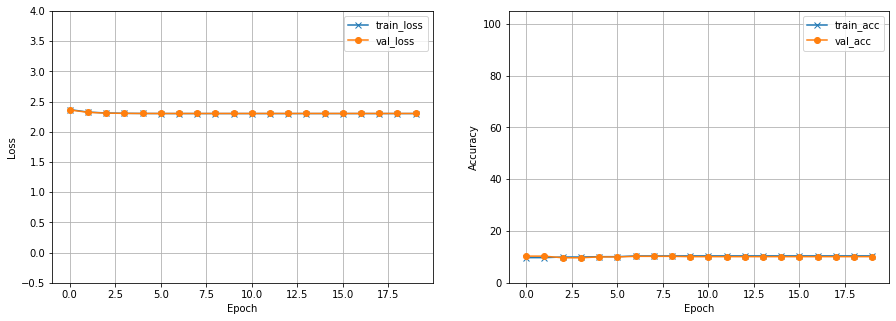

In [14]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 256,
    'channel2': 256,
    'mid_dims': [2, 2],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Underfitting: mid_dims = [2,2]**

---

We see 10.30% validation accuracy when mid_dims = [2,2]. This is a relatively small value for an optimal accuracy. Generally, when the parameters are good, the accuracy is between 47-50%. Therefore, this hidden layer width value underfits the model. 

  0%|          | 0/20 [00:00<?, ?it/s]

The highest validation accuracy is 45.26 percent
The highest training accuracy is 94.98 percent


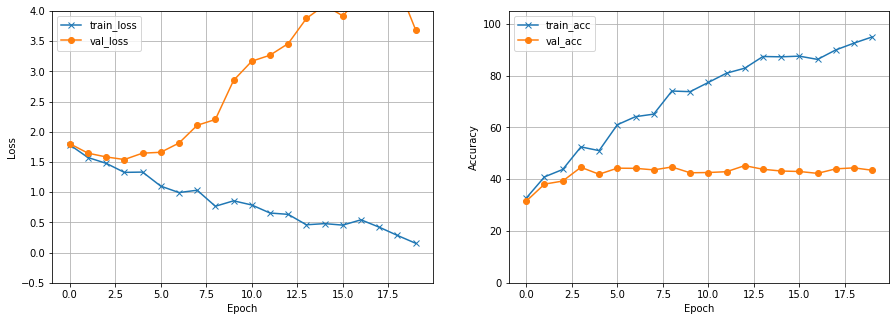

In [15]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 256,
    'channel2': 256,
    'mid_dims': [2048, 2048],
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Overfitting: mid_dims = [2048,2048]**

---

We see 45.26% validation accuracy when mid_dims = [2048,2048]. The accuracy started to decrease from the optimal value. Therefore, this hidden layer width value overfits the model.

## Experiment: Linear Layer Depth `[2 marks]`

Use the following configuration as default (you may use either `cpu` or `cuda`):
~~~
args = {
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 256,
    'channel2': 256,
    'mid_dims': [256]*K,
    'act_name': 'relu',
    'device': 'cuda'
}
~~~
and experiment different `args['mid_dims'] = [256]*K` with different integer `K` (note that `args['mid_dims']` is a list of integers). Report one configuration that underfit the network, and one configuration that overfits the network. Make sure you provide the `args` that you used, and the plots generated by that `args`. You can avoid printing the loss and models by setting `print_model=False`, `print_loss=False` in `spawn_train_show`.

  0%|          | 0/20 [00:00<?, ?it/s]

The highest validation accuracy is 51.66 percent
The highest training accuracy is 87.60 percent


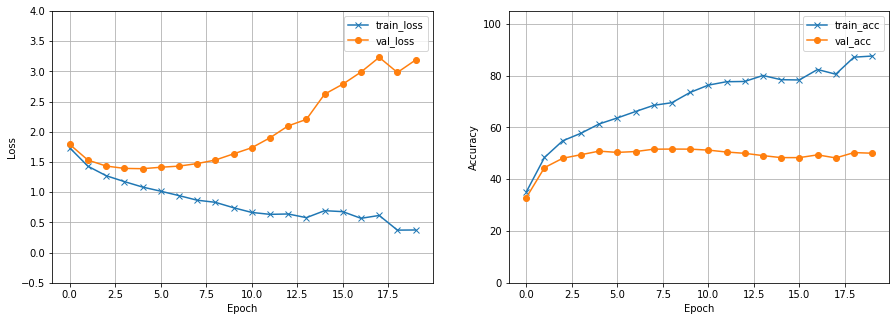

In [16]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 256,
    'channel2': 256,
    'mid_dims': [256]*0,
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Underfitting: mid_dims: [256]*0**

---

We see 51.66% validation accuracy when mid_dims = [256]*0. K=0 means there is no hidden layer, we decrease the complexity of the model. When I increased the complexity with K=1,2,3... the accuracy started to decrease from 51% to 49% or 48%. Therefore, I couldn't find any K value that underfits the model.

  0%|          | 0/20 [00:00<?, ?it/s]

The highest validation accuracy is 10.26 percent
The highest training accuracy is 10.40 percent


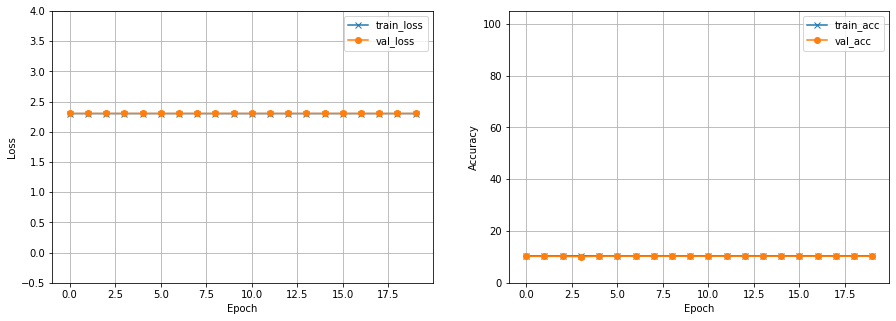

In [17]:
args = {
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 256,
    'channel2': 256,
    'mid_dims': [256]*16,
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Overfitting: mid_dims: [256]*16**

---

We see 10.26% validation accuracy when mid_dims = [256]*16. This accuracy value is so small compared to other accuracy values obtained by using smaller K values. Also, validation loss is relatively high over different epochs, and both train and validation accuracy are low. Therefore, very complex models that includes lots of hidden layers can cause overfitting.

## Experiment: Activations `[2 marks]`

Use the following configuration as default (you may use either `cpu` or `cuda`):
~~~
args = {
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 128,
    'channel2': 256,
    'mid_dims': [512, 512],
    'act_name': 'relu',
    'device': 'cuda'
}
~~~
and experiment on `args['act_name']` with the values `'relu', 'identity', 'tanh', 'sigmoid'`. Report one configuration that underfit the network, and one configuration that overfits the network. Make sure you provide the `args` that you used, and the plots generated by that `args`. You can avoid printing the loss and models by setting `print_model=False`, `print_loss=False` in `spawn_train_show`.

  0%|          | 0/20 [00:00<?, ?it/s]

The highest validation accuracy is 10.10 percent
The highest training accuracy is 10.40 percent


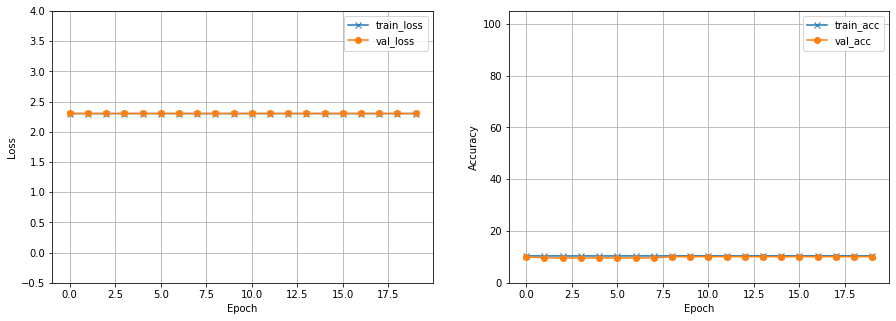

In [18]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 128,
    'channel2': 256,
    'mid_dims': [512, 512],
    'act_name': 'sigmoid',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Underfitting: act_name: sigmoid**

---

Validation and train loss is relatively high and constant. Also, we obtain 10.10% as the highest valudation accuracy. It is very low compared to default value. Model is underfitted by sigmoid activation function.

  0%|          | 0/20 [00:00<?, ?it/s]

The highest validation accuracy is 44.36 percent
The highest training accuracy is 89.78 percent


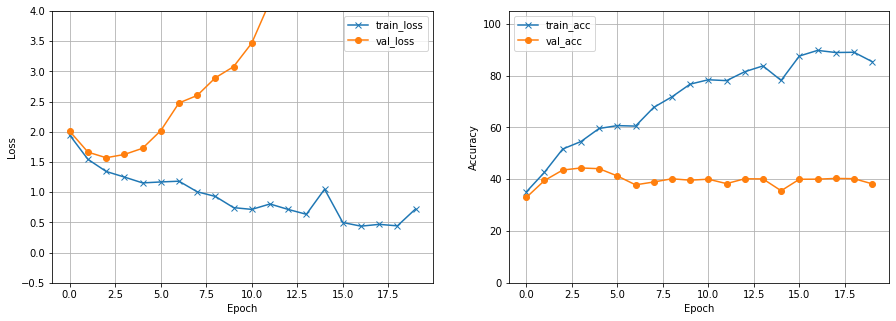

In [19]:
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 20,
    'channel1': 128,
    'channel2': 256,
    'mid_dims': [512, 512],
    'act_name': 'identity',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Overfitting: act_name: identity**

---

Validation loss is increasing rapidly. There is a huge difference between train and validation loss, also between train and validation accuracy. Also, we got 44.36% validation accuracy at most. When we use ReLU, this value was 49.00%. So, model is overfitting by identity activation function.

## Creating the best model `[2 marks]`

After learning the effects of various hyper-parameters, it is time to create your final model. Experiment with different configurations in `args` and report your best hyperparameters, the training, validation accuracies. Provide the worst, and best configurations in terms of validation accuracies below:

  0%|          | 0/3 [00:00<?, ?it/s]

The highest validation accuracy is 10.22 percent
The highest training accuracy is 10.40 percent


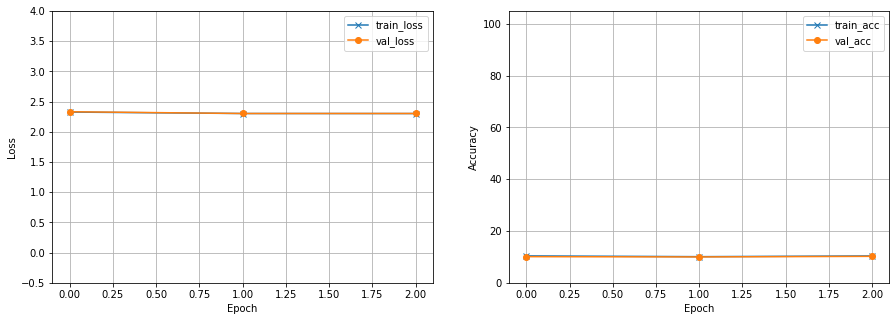

In [20]:
# Worst
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 3,
    'channel1': 2,
    'channel2': 2,
    'mid_dims': [256]*16,
    'act_name': 'sigmoid',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

  0%|          | 0/8 [00:00<?, ?it/s]

The highest validation accuracy is 50.38 percent
The highest training accuracy is 62.32 percent


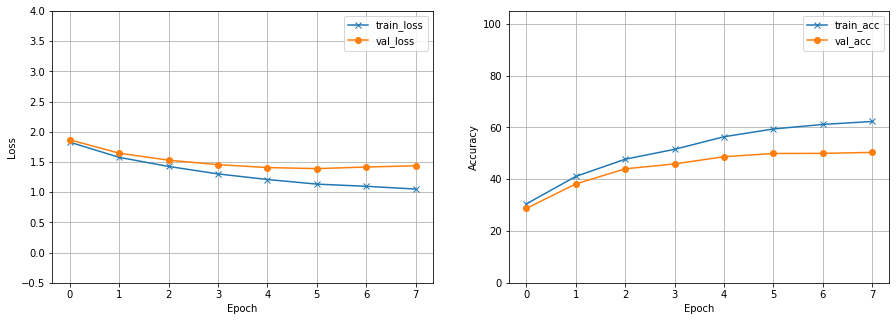

In [21]:
# Best
args = {
    # TODO
    'lr': 1e-3,
    'epoch': 8,
    'channel1': 256,
    'channel2': 256,
    'mid_dims': [32]*1,
    'act_name': 'relu',
    'device': 'cuda'
}
trained_model = hw_utils.spawn_train_show(args, train_loader, val_loader, print_model=False, print_loss=False)

**Parameters Yields the Highest Accuracy:**

---



*   learning rate = 1e-3
*   epoch = 8
*   channel size = 2x2
*   hidden layer = 1 hidden layer with size 32
*   activation function = ReLU

In machine learning, we often split the dataset into training, validation and test set. Your "best hyper-parameters" above should be chosen based on the model performance on the validation set. After choosing the best hyper-parameters, report your results on the test set. 

In [22]:
_, test_acc = hw_utils.test(args, trained_model, test_loader)
print('The test accuracy is %.2f percent' % (test_acc))

The test accuracy is 50.50 percent


# Playing with SOTA `[4 marks]`

[Mask R-CNN](https://arxiv.org/abs/1703.06870) is one of the state-of-the-art in the image segmentation task. Image segmentation is a more general version of an object detection task. Instead of labelling the class of a bouding box, a model needs to assign a label to each pixel. You are going to experiment Mask R-CNN with your own choice of images. 

Lets import the model from the PyTorch model zoo:

In [23]:
import hw_utils
import torchvision
device = 'cuda'
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

The following example shows you how to apply Mask R-CNN on your choice of images. The parameter `im_path` should point to an image path in your directory; `device` can be set above to either `cuda` or `cpu`; `topk` shows the topk most confident objects detected by the network.

The demo image is taken [here](https://www.ubyssey.ca/blog/an-interview-with-the-birb/).

Visualizing birb.jpg
Resized image size: 600, 401


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


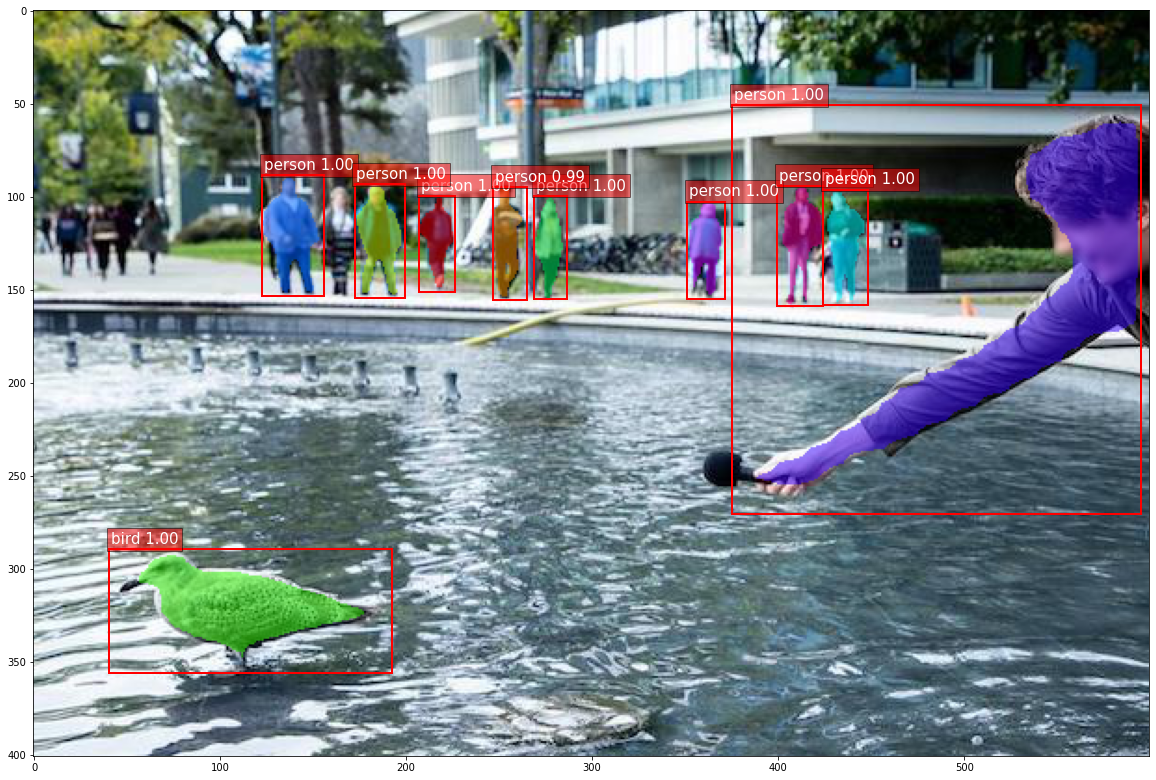

In [24]:
hw_utils.apply_mask_rcnn(im_path='birb.jpg', model=model, device=device, topk=10)

**Experiment with images of your choice and pick one image that this network would work and two images that this network will fail. Give two sentences to summarize when the model would work and when won't.**

Positive Example: this network would work on this image

In [31]:
from IPython.display import display, Image

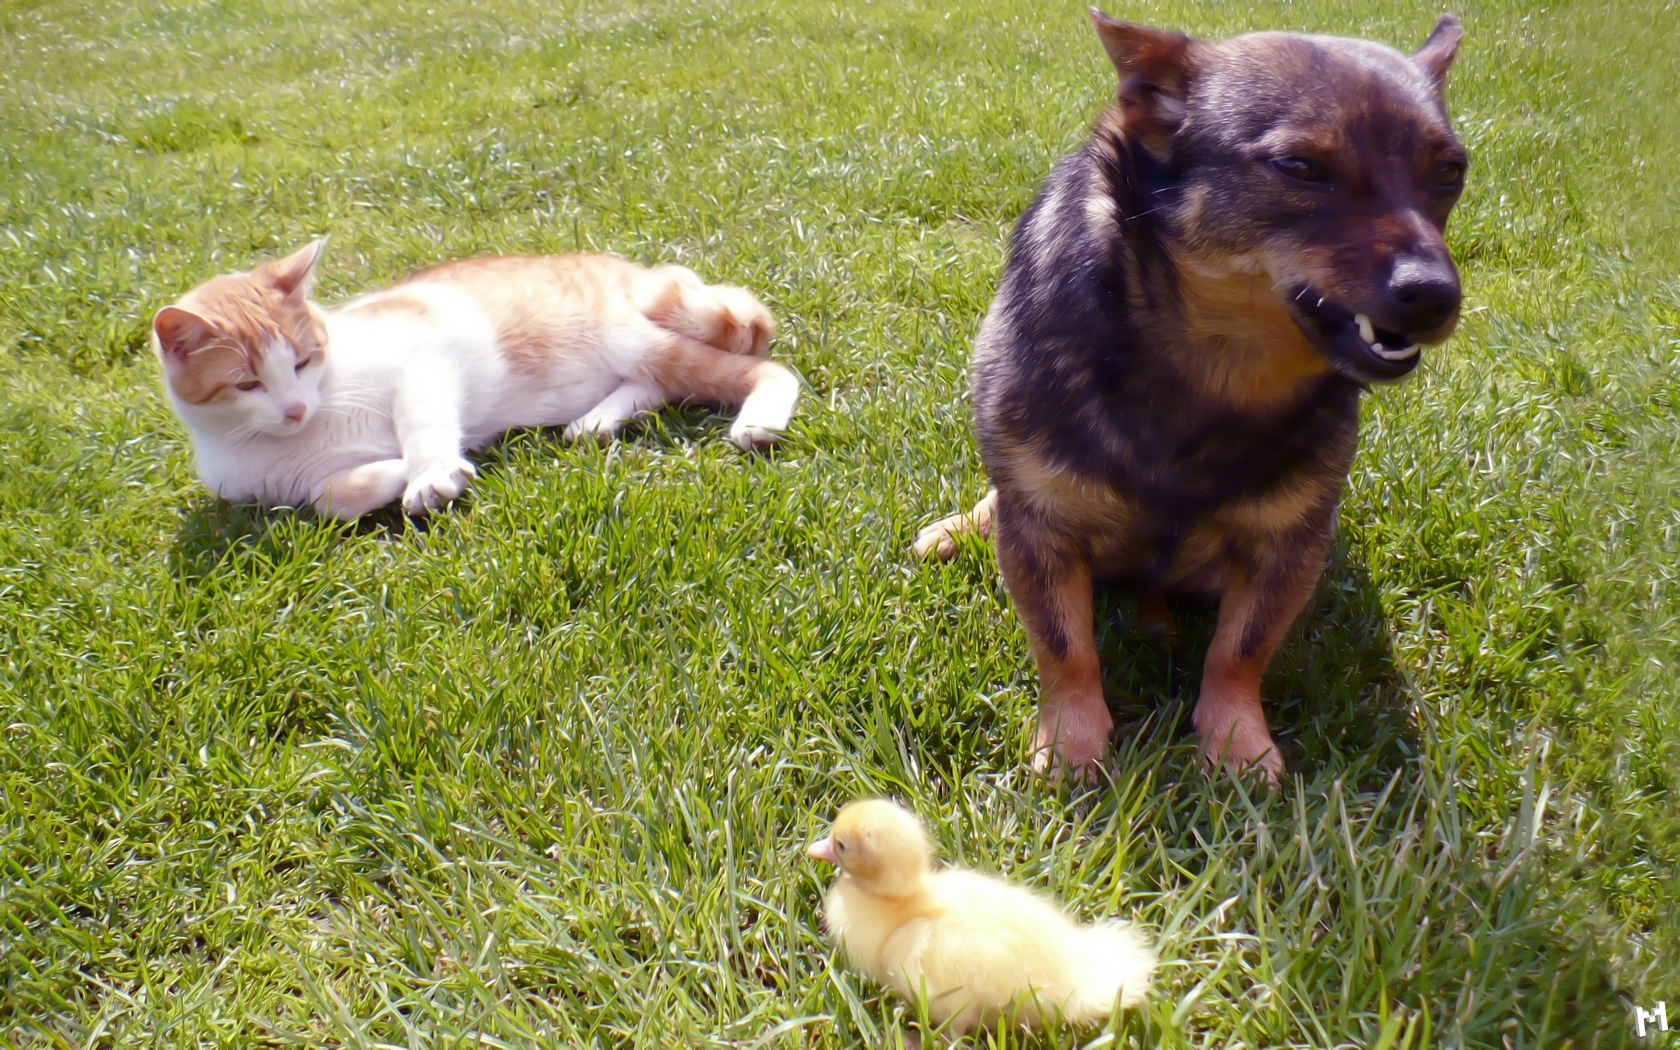

In [32]:
# https://www.deviantart.com/mimo86/art/Dog-cat-and-duck-84607571
display(Image('1.jpg'))

Visualizing 1.jpg
Resized image size: 600, 375


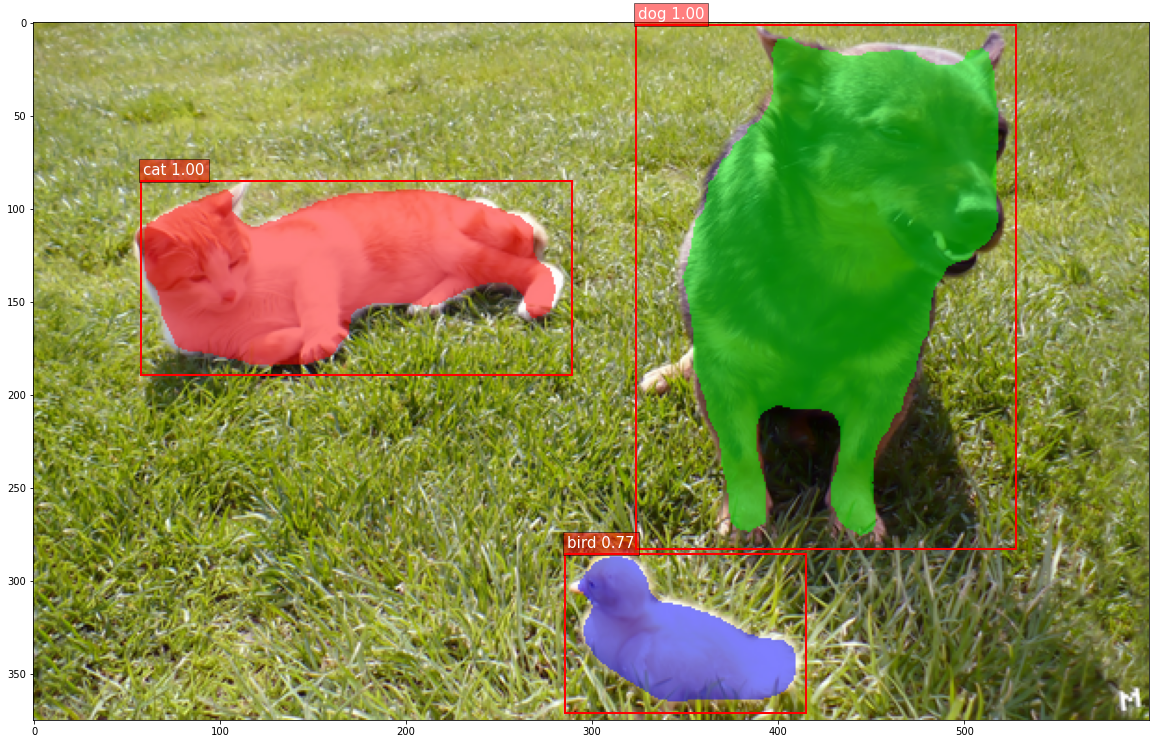

In [33]:
hw_utils.apply_mask_rcnn(im_path='1.jpg', model=model, device=device, topk=3)

Negative Examples: this network would fail on two images

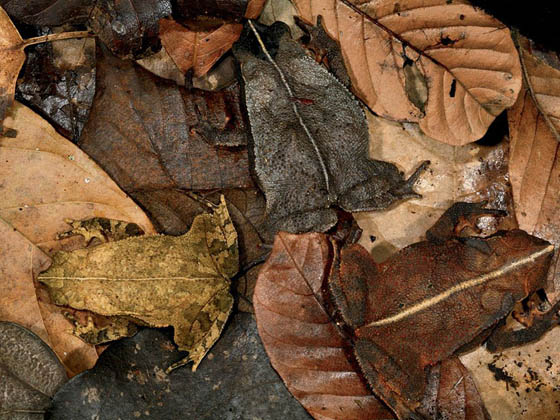

In [34]:
# https://www.designswan.com/archives/25-amazing-photos-of-animal-camouflage-can-you-spot-them.html
display(Image('13.jpeg'))

There are 3 frogs in this image.

Visualizing 13.jpeg
Resized image size: 600, 450


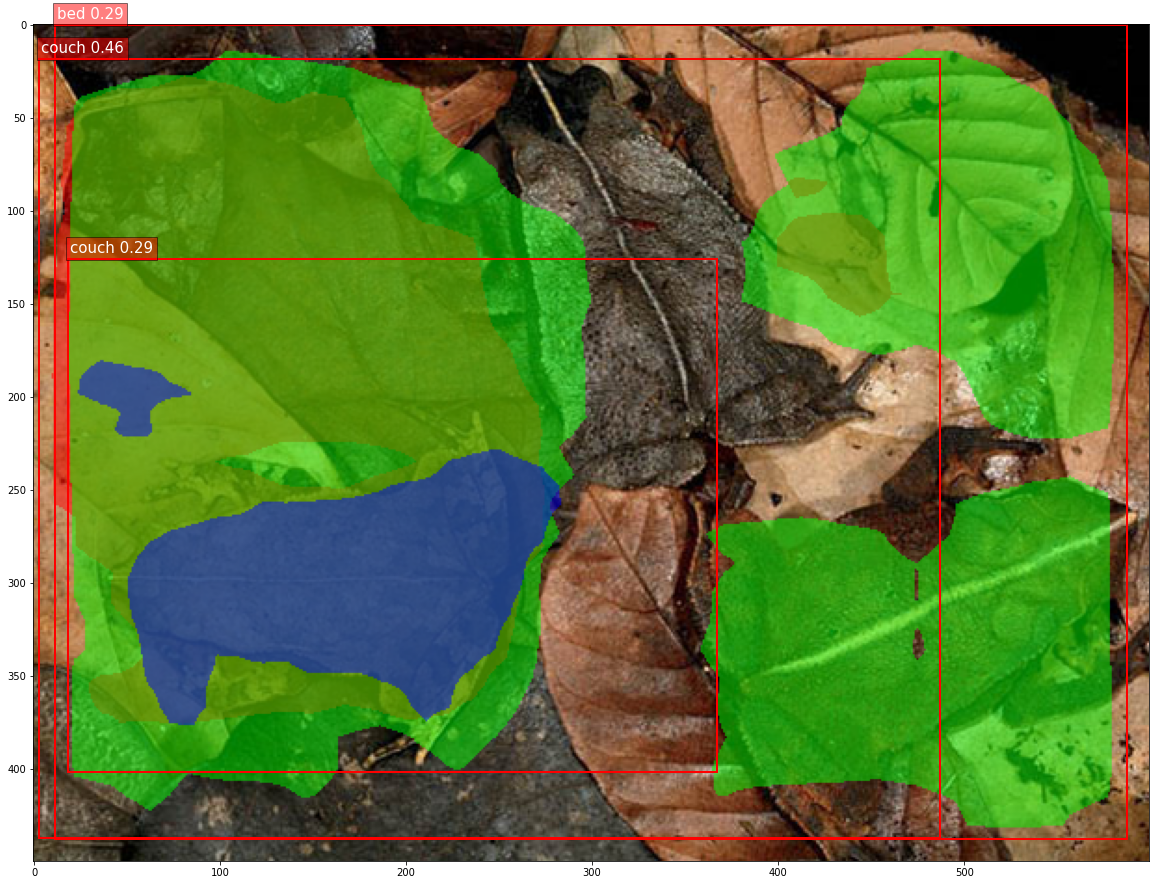

In [35]:
hw_utils.apply_mask_rcnn(im_path='13.jpeg', model=model, device=device, topk=3)

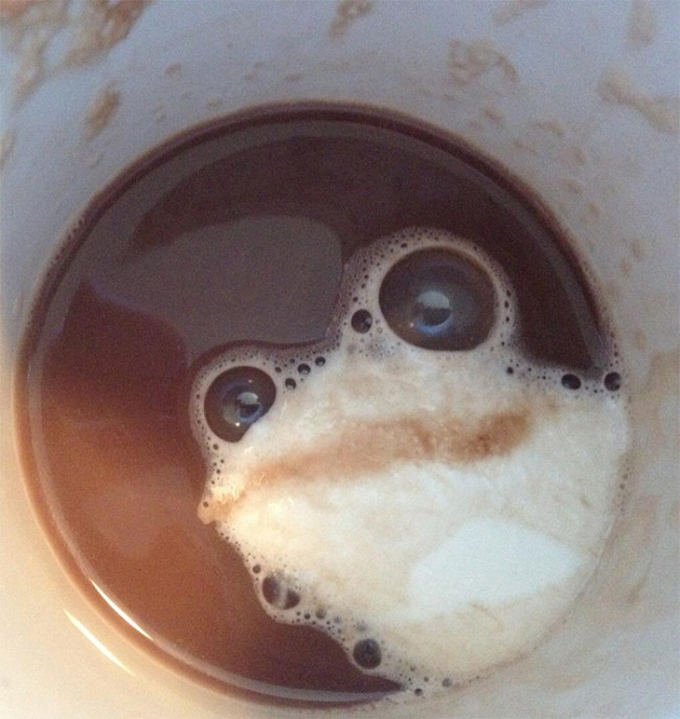

In [36]:
# http://www.cruzeirodovale.com.br/colunas/vida-e-ciencia/pareidolia/
display(Image('18.jpeg'))

Visualizing 18.jpeg
Resized image size: 567, 600


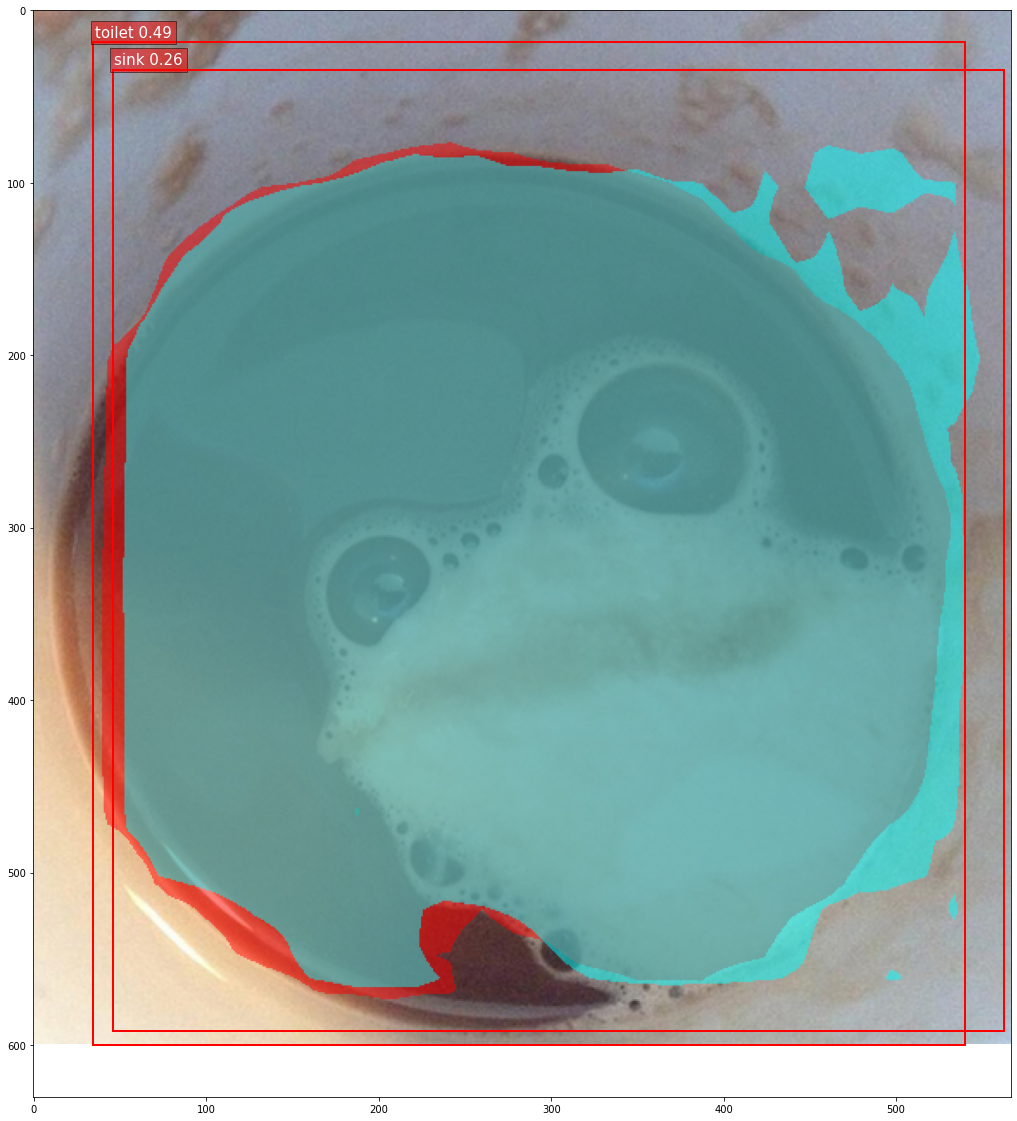

In [37]:
hw_utils.apply_mask_rcnn(im_path='18.jpeg', model=model, device=device, topk=2)

When it will work?
- When the objects have certain boundaries different from the background, also they are not occluded, they can clearly distinguishable from rest of the image.

When it will fail?
- When the objects are indistinguishable from the background, or they look like something else.

# Submission Instructions

- Include all plots and answers on this Jupyter notebook.
- Download the Jupyter notebook with the created plots and answers.
- Submit your notebook using the naming convention `firstname_lastname_student_id.ipynb` on Canvas.

© 2020 Zicong Fan and Leonid Sigal All Rights Reserved